In [ ]:
!pip install pyro-ppl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 10.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
import h5py
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from torch.utils.data import  SubsetRandomSampler
import shutil

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule

In [ ]:
!pip install wandb
import wandb
wandb.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
def find_images_without_masks(image_dir, mask_dir):
    images = os.listdir(image_dir)
    masks = os.listdir(mask_dir)

    images_without_masks = [img for img in images if img not in masks]
    images_with_masks = [img for img in images if img in masks]

    return images_with_masks, images_without_masks

# Example usage
image_dir = r"/content/gdrive/MyDrive/data/Mixed/CXR_Png/"
mask_dir = r"/content/gdrive/MyDrive/data/Mixed/masks/"

images_with_masks, images_without_masks = find_images_without_masks(image_dir, mask_dir)
print("Images with corresponding masks:", len(images_with_masks))
print("Images without corresponding masks:", images_without_masks)
print("No. of Images without corresponding masks:", len(images_without_masks))

Images with corresponding masks: 801
Images without corresponding masks: []
No. of Images without corresponding masks: 0


In [ ]:
# Define a Bayesian double convolutional layer
class BayesianDoubleConv(PyroModule):
    def __init__(self, in_channels, out_channels):
        super(BayesianDoubleConv, self).__init__()
        self.conv1 = PyroModule[nn.Conv2d](in_channels, out_channels, 3, padding=1)
        self.conv2 = PyroModule[nn.Conv2d](out_channels, out_channels, 3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        return x

# Define the Bayesian UNet architecture
class BayesianUNet(PyroModule):
    def __init__(self, n_class):
        super(BayesianUNet, self).__init__()

        self.dconv_down1 = BayesianDoubleConv(1, 64)
        self.dconv_down2 = BayesianDoubleConv(64, 128)
        self.dconv_down3 = BayesianDoubleConv(128, 256)
        self.dconv_down4 = BayesianDoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = BayesianDoubleConv(256 + 512, 256)
        self.dconv_up2 = BayesianDoubleConv(128 + 256, 128)
        self.dconv_up1 = BayesianDoubleConv(128 + 64, 64)

        self.conv_last = PyroModule[nn.Conv2d](64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

# Define the Bayesian model using Pyro's forward function
def model(x, y=None):
    pyro.module("unet", BayesianUNet(n_class=1))
    p_y = pyro.sample("out", dist.Normal(unet(x), 1.), obs=y)
    return p_y

In [ ]:
def negative_log_likelihood(y_true, y_pred, sigma=1.0):
    dist = tfd.Normal(loc=y_pred, scale=sigma)
    return -tf.reduce_sum(dist.log_prob(y_true))

In [ ]:
# Define CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        filename = str(self.images[idx])
        mask_name = os.path.join(self.mask_dir, filename)

        try:
            image = Image.open(img_name).convert("L")  # Convert to grayscale
            mask = Image.open(mask_name).convert("L")  # Convert to grayscale

            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)

            # Check for NaN values in images or masks
            if torch.isnan(image).any() or torch.isnan(mask).any():
                print(f"NaN values encountered in image or mask at index {idx}. Skipping this sample.")
                # Return empty tensors if NaN values are encountered
                image = torch.empty((1, 128, 128))
                mask = torch.empty((1, 128, 128))

        except Exception as e:
            print(f"Error loading image or mask: {e}")
            # Return empty tensors if an error occurs
            image = torch.empty((1, 128, 128))
            mask = torch.empty((1, 128, 128))

        return {'image': image, 'mask': mask}

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Define dataset
dataset = CustomDataset(image_dir, mask_dir, transform=transform)

# Get the number of samples in the dataset
num_samples = len(dataset)

# Create a random sampler with the correct number of samples
sampler = SubsetRandomSampler(range(num_samples))

# Create dataloader using the sampler
dataloader = DataLoader(dataset, batch_size=16, sampler=sampler)

# Verify the dataloader
for batch in dataloader:
    images = batch['image']
    masks = batch['mask']
    print("Batch of images shape:", images.shape)
    print("Batch of masks shape:", masks.shape)
    break


Batch of images shape: torch.Size([16, 1, 128, 128])
Batch of masks shape: torch.Size([16, 1, 128, 128])


In [ ]:

# Define loss function
def loss_fn(predictive_mean, predictive_std, target):
    log_likelihood = -torch.nn.functional.binary_cross_entropy_with_logits(predictive_mean, target)
    kl_divergence = -0.5 * torch.sum(1 + torch.log(predictive_std.pow(2)) - predictive_mean.pow(2) - predictive_std.pow(2))
    return log_likelihood + kl_divergence

# Example usage
dropout_rate = 0.1
n_classes = 1  # Change this according to your task
model = BayesianUNet(n_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Change this to your desired device

# Move the model to the device
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001)  # Adjust learning rate as needed

# Initialize Weights and Biases
#wandb.init(project="your_project_name")

# Define a training loop
for epoch in range(20):
    epoch_loss = 0.0

    for i, data in enumerate(dataloader):
        inputs, labels = data['image'].to(device), data['mask'].to(device)

        # Forward pass (sampling multiple predictions)
        predictive_means = []
        predictive_stds = []
        for _ in range(10):  # Sample 10 times for Monte Carlo approximation
            predictive_mean = model(inputs)
            predictive_std = torch.ones_like(predictive_mean)  # Assuming fixed standard deviation for simplicity
            predictive_means.append(predictive_mean)
            predictive_stds.append(predictive_std)

        # Calculate loss
        predictive_mean = torch.stack(predictive_means).mean(dim=0)
        predictive_std = torch.stack(predictive_stds).mean(dim=0)
        loss = loss_fn(predictive_mean, predictive_std, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Log loss for every 10 batches
        wandb.log({"Epoch": epoch+1, "Batch": i+1, "Loss": loss.item()})
        print(f"Epoch [{epoch+1}/{20}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}")



    # Calculate average epoch loss
    epoch_loss /= len(dataloader)
    wandb.log({"Epoch":epoch+1, "Average Loss": epoch_loss})
    print(f"Epoch [{epoch+1}/{20}], Average Loss: {epoch_loss}")

    # Early stopping criterion


Epoch [1/20], Batch [1/51], Loss: 17.537813186645508
Epoch [1/20], Batch [2/51], Loss: 17.63199234008789
Epoch [1/20], Batch [3/51], Loss: 17.692880630493164
Epoch [1/20], Batch [4/51], Loss: 17.484920501708984
Epoch [1/20], Batch [5/51], Loss: 17.37544822692871
Epoch [1/20], Batch [6/51], Loss: 17.544034957885742
Epoch [1/20], Batch [7/51], Loss: 17.69451332092285
Epoch [1/20], Batch [8/51], Loss: 17.657020568847656
Epoch [1/20], Batch [9/51], Loss: 17.540386199951172
Epoch [1/20], Batch [10/51], Loss: 17.66140365600586
Epoch [1/20], Batch [11/51], Loss: 17.37714958190918
Epoch [1/20], Batch [12/51], Loss: 17.471294403076172
Epoch [1/20], Batch [13/51], Loss: 17.388822555541992
Epoch [1/20], Batch [14/51], Loss: 17.63839340209961
Epoch [1/20], Batch [15/51], Loss: 17.267751693725586
Epoch [1/20], Batch [16/51], Loss: 17.608245849609375
Epoch [1/20], Batch [17/51], Loss: 17.3182430267334
Epoch [1/20], Batch [18/51], Loss: 17.40791893005371
Epoch [1/20], Batch [19/51], Loss: 17.31507682

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/data/AC_Mixed_Bayesian_Final_0.7.pth")
print("Finished Training")

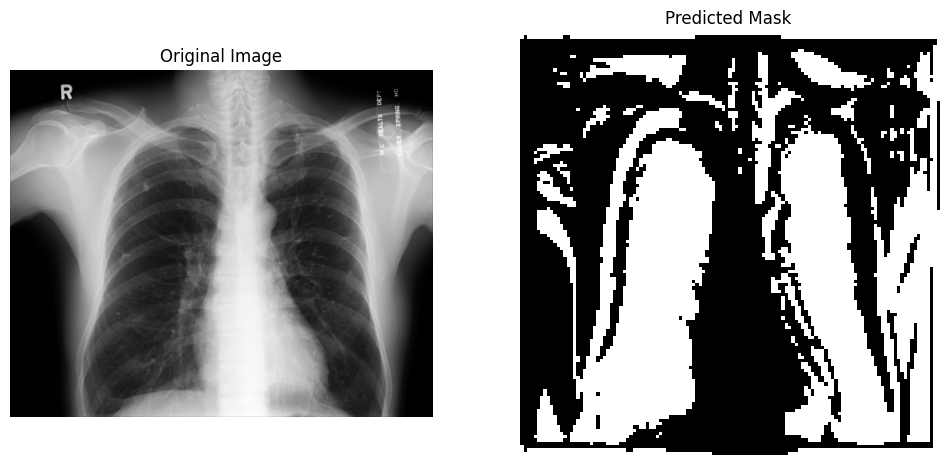

In [ ]:
checkpoint_path = r"/content/gdrive/MyDrive/data/AC_Mixed_Bayesian_Final_0.6.pth"

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BayesianUNet(n_class=1).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()  # Set model to evaluation mode

# Load the new chest X-ray image
new_image_path = r'/content/gdrive/My Drive/data/Mixed/CXR_Png/MCUCXR_0354_1.png'
new_image = Image.open(new_image_path).convert("L")  # Convert to grayscale
new_image_tensor = transform(new_image).unsqueeze(0).to(device)  # Preprocess and move to device

# Perform inference
with torch.no_grad():
    output_mean = model(new_image_tensor)  # Assuming model returns the mean of the output distribution

# Define a fixed standard deviation or use a learned parameter from the model
output_std = torch.ones_like(output_mean) * 0.1  # Example: using a fixed standard deviation of 0.1

# Convert output mean to probabilities using sigmoid activation
sigmoid = nn.Sigmoid()
output_probabilities = sigmoid(output_mean)

# Convert output probabilities to binary mask
threshold = 0.5
predicted_mask = (output_probabilities > threshold).float()



# Display original image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(new_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')
plt.show()

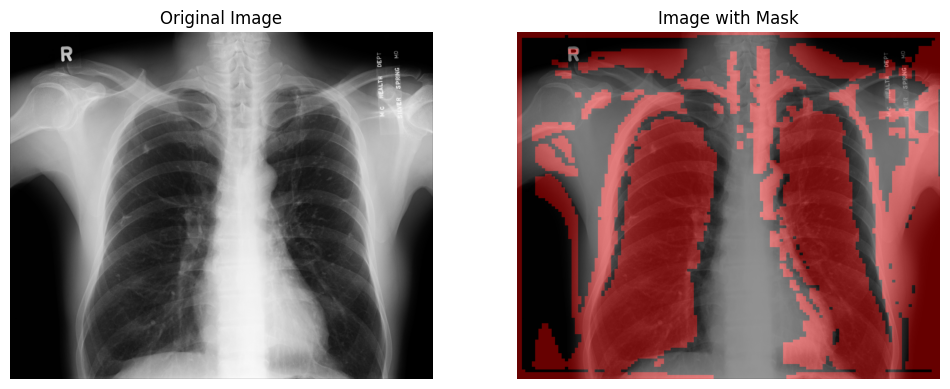

In [ ]:
import cv2


# Perform inference
with torch.no_grad():
    output = model(new_image_tensor)

# Convert output to probabilities using sigmoid activation
sigmoid = nn.Sigmoid()
output_probabilities = sigmoid(output)

# Convert output probabilities to binary mask
threshold = 0.5
predicted_mask = (output_probabilities > threshold).float()

# Convert PIL image to numpy array
new_image_np = np.array(new_image)

# Resize predicted mask to original image size
predicted_mask_np = cv2.resize(predicted_mask.squeeze().cpu().numpy(), (new_image_np.shape[1], new_image_np.shape[0]))

# Create an empty RGB image
mask_rgb = np.zeros((new_image_np.shape[0], new_image_np.shape[1], 3), dtype=np.uint8)

# Apply mask to the RGB image
mask_rgb[predicted_mask_np > 0] = [255, 0, 0]  # Red for mask

# Convert grayscale image to RGB
new_image_rgb = cv2.cvtColor(new_image_np, cv2.COLOR_GRAY2RGB)

# Superimpose the mask on the image
superimposed_img = cv2.addWeighted(new_image_rgb, 0.6, mask_rgb, 0.4, 0)

# Display original image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(new_image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(superimposed_img)
axes[1].set_title('Image with Mask')
axes[1].axis('off')
plt.show()
